# Computing the value function : 

This notebooks take the Liverpool tracking data in the google format from the google-tracking notebook, and uses our agent to compute the value function. 

You can plug your google data and the checkopint you want to use. 

In [2]:
import numpy as np 
import six

In [2]:
import multiprocessing
import os
from absl import app
from absl import flags
from baselines import logger
from baselines.bench import monitor
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.ppo2 import ppo2
import gfootball.env as football_env
from gfootball.examples import models  

In [3]:
def load_dump(dump_file):
    dump = []
    with open(dump_file, 'rb') as in_fd:
      while True:
        try:
          step = six.moves.cPickle.load(in_fd)
        except EOFError:
          return dump
        dump.append(step)
    return dump

In [40]:
data = load_dump('full_info_liverpool_leicester.dump')

In [1]:
from gfootball.env.players.ppo2_cnn import Player



player_config = {'index': 0, 'left_players': 1, 'right_players': 0,
                 'policy': 'gfootball_impala_cnn', 'stacked': True, 'checkpoint': '/checkopints/11_vs_11_selfplay_last'}
agent = Player(player_config, env_config={})



Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





In [43]:
agent.reset()

In [44]:
env = football_env.create_environment(env_name='11_vs_11_stochastic')
observation = env.reset()
agent.reset()
done = False
#while not done:
    #action = agent.take_action([observation])
    #observation, reward, done, info = env.step(action)

In [46]:
"""The first plane P holds the position of players on the left
        team, P[y,x] is 255 if there is a player at position (x,y), otherwise,
        its value is 0.
        The second plane holds in the same way the position of players
        on the right team.
        The third plane holds the position of the ball.
        The last plane holds the active player."""

'The first plane P holds the position of players on the left\n        team, P[y,x] is 255 if there is a player at position (x,y), otherwise,\n        its value is 0.\n        The second plane holds in the same way the position of players\n        on the right team.\n        The third plane holds the position of the ball.\n        The last plane holds the active player.'

In [47]:
observation.shape

(72, 96, 4)

In [48]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from six.moves import range


SMM_WIDTH = 96
SMM_HEIGHT = 72

SMM_LAYERS = ['left_team', 'right_team', 'ball', 'active']

# Normalized minimap coordinates
MINIMAP_NORM_X_MIN = -1.0
MINIMAP_NORM_X_MAX = 1.0
MINIMAP_NORM_Y_MIN = -1.0 / 2.25
MINIMAP_NORM_Y_MAX = 1.0 / 2.25

_MARKER_VALUE = 255


def get_smm_layers(config):
  return SMM_LAYERS


def mark_points(frame, points):
  """Draw dots corresponding to 'points'.
  Args:
    frame: 2-d matrix representing one SMM channel ([y, x])
    points: a list of (x, y) coordinates to be marked
  """
  for p in range(len(points) // 2):
    x = int((points[p * 2] - MINIMAP_NORM_X_MIN) /
            (MINIMAP_NORM_X_MAX - MINIMAP_NORM_X_MIN) * frame.shape[1])
    y = int((points[p * 2 + 1] - MINIMAP_NORM_Y_MIN) /
            (MINIMAP_NORM_Y_MAX - MINIMAP_NORM_Y_MIN) * frame.shape[0])
    x = max(0, min(frame.shape[1] - 1, x))
    y = max(0, min(frame.shape[0] - 1, y))
    frame[y, x] = _MARKER_VALUE


def generate_smm(observation, config=None,
                 channel_dimensions=(SMM_WIDTH, SMM_HEIGHT)):
  """Returns a list of minimap observations given the raw features for each
  active player.
  Args:
    observation: raw features from the environment
    channel_dimensions: resolution of SMM to generate
  Returns:
    (N, H, W, C) - shaped np array representing SMM. N stands for the number of
    players we are controlling.
  """
  frame = np.zeros((len(observation), channel_dimensions[1],
                    channel_dimensions[0], len(get_smm_layers(config))),
                   dtype=np.uint8)

  for o_i, o in enumerate(observation):
    for index, layer in enumerate(get_smm_layers(config)):
      if layer not in o:
        continue
      if layer == 'active':
        if o[layer] == -1:
          continue
        mark_points(frame[o_i, :, :, index],
                    np.array(o['left_team'][o[layer]]).reshape(-1))
      else:
        mark_points(frame[o_i, :, :, index], np.array(o[layer]).reshape(-1))
  return frame

In [49]:
channel_dimensions=(SMM_WIDTH, SMM_HEIGHT)
frame = np.zeros((channel_dimensions[1],channel_dimensions[0]))

# Let's get the value for Liverpool data : 

In [50]:
len(data[0][0])

125

In [51]:
def _left_parser(tab,i):
    coord = []
    tab_ = tab[0][0][i]['left_team_positions']
    for list_ in tab_:
        for value in list_:
            coord.append(value)
    return coord

def _right_parser(tab,i):
    coord = []
    tab_ = tab[0][0][i]['right_team_positions']
    for list_ in tab_:
        for value in list_:
            coord.append(value)
    return coord

def _ball_parser(tab,i):
    tab_ = tab[0][0][i]['ball_position']
    return tab_[:-1]

def _active_parser(tab,i):
    tab_left = tab[0][0][i]['left_team_positions']
    tab_ball = tab[0][0][i]['ball_position'][:-1]
    min_dist = 1000000
    for indx,list_ in enumerate(tab_left):
        dist = (list_[0] - tab_ball[0])**2 + (list_[1] - tab_ball[1])**2
        if dist < min_dist:
            min_dist = dist
            select = indx 
    return tab_left[select]

In [52]:
def _build_obs(tab,i):
    frame = np.zeros((channel_dimensions[1],channel_dimensions[0],4))
    mark_points(frame[:,:,0], _left_parser(tab,i))
    mark_points(frame[:,:,1], _right_parser(tab,i))
    mark_points(frame[:,:,2], _ball_parser(tab,i))
    mark_points(frame[:,:,3], _active_parser(tab,i))
    return frame

In [53]:
def _build_obs_stacked(tab,i):
    frame = np.zeros((channel_dimensions[1],channel_dimensions[0],16))
    mark_points(frame[:,:,0], _left_parser(tab,i))
    mark_points(frame[:,:,1], _right_parser(tab,i))
    mark_points(frame[:,:,2], _ball_parser(tab,i))
    mark_points(frame[:,:,3], _active_parser(tab,i))
    to_add = min((i+1),len(tab[0][0])-1)
    mark_points(frame[:,:,4], _left_parser(tab,to_add))
    mark_points(frame[:,:,5], _right_parser(tab,to_add))
    mark_points(frame[:,:,6], _ball_parser(tab,to_add))
    mark_points(frame[:,:,7], _active_parser(tab,to_add))
    to_add = min((i+2),len(tab[0][0])-1)
    mark_points(frame[:,:,8], _left_parser(tab,to_add))
    mark_points(frame[:,:,9], _right_parser(tab,to_add))
    mark_points(frame[:,:,10], _ball_parser(tab,to_add))
    mark_points(frame[:,:,11], _active_parser(tab,to_add))
    to_add = min((i+3),len(tab[0][0])-1)
    mark_points(frame[:,:,12], _left_parser(tab,to_add))
    mark_points(frame[:,:,13], _right_parser(tab,to_add))
    mark_points(frame[:,:,14], _ball_parser(tab,to_add))
    mark_points(frame[:,:,15], _active_parser(tab,to_add))

    return frame
    

In [54]:
observations = {
    'frame_count':[],
    'obs':[],
    'value':[]
}

In [55]:
for i in range(len(data[0][0])):
    obs = _build_obs_stacked(data,i)
    observations['frame_count'].append(i)
    observations['obs'].append(obs)

In [56]:
agent.take_action([observations['obs'][0]])

/Users/paulgarnier/Documents/github/football/gfootball/env/observation_preprocessing.py:83: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if layer not in o:


(array([14]),
 array([-0.07783899], dtype=float32),
 None,
 array([3.0581164], dtype=float32))

In [57]:
agent._policy.value([observations['obs'][120]])

array([0.06304608], dtype=float32)

In [58]:
for indx,obs in enumerate(observations['obs']):
    value = agent._policy.value([obs])
    observations['value'].append(value[0])

In [59]:
import seaborn as sns
import pandas as pd

In [60]:
observations['value']

[-0.13671872,
 -0.13671872,
 -0.13671872,
 -0.13671872,
 -0.12542975,
 -0.11751981,
 -0.028834239,
 -0.1333991,
 -0.088491306,
 -0.08772334,
 -0.1118809,
 -0.07498057,
 -0.119245514,
 -0.0074533224,
 -0.04909537,
 -0.16225514,
 -0.18097863,
 -0.16825522,
 -0.15068021,
 -0.152248,
 -0.13815546,
 -0.15129033,
 -0.10887492,
 -0.117340654,
 -0.011270724,
 0.02560743,
 0.06355703,
 0.041176885,
 0.017369926,
 -0.025271043,
 -0.021885708,
 -0.023691252,
 0.031027086,
 -0.0154887065,
 0.025271446,
 0.005156912,
 -0.057583425,
 -0.024605252,
 -0.025889445,
 -0.0674309,
 -0.065700784,
 -0.09377858,
 -0.12269638,
 -0.054345448,
 -0.10123868,
 -0.1437596,
 -0.056008324,
 -0.0096383765,
 -0.13052967,
 -0.16917972,
 -0.030084983,
 -0.075775415,
 -0.04180304,
 -0.15418379,
 0.011236772,
 -0.10785243,
 0.031875372,
 -0.013136119,
 -0.13672481,
 -0.04862458,
 -0.06694631,
 -0.18328534,
 -0.04804596,
 -0.018771052,
 -0.026237119,
 -0.07485695,
 -0.091722004,
 -0.0698725,
 -0.058863543,
 -0.013487324,
 

In [61]:
df_dict = {
    'frame_count':observations['frame_count'],
    'value':observations['value']
}
df = pd.DataFrame(df_dict)

In [62]:
df['dValue'] = df['value'].diff()

In [63]:
df['dValue'] = df['dValue'].fillna(0)

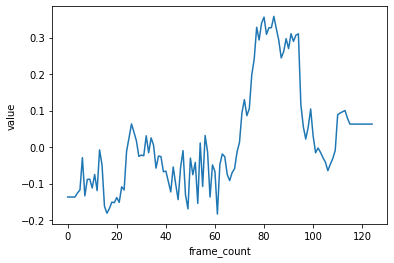

In [64]:
sns.lineplot(x="frame_count", y="value",data=df)

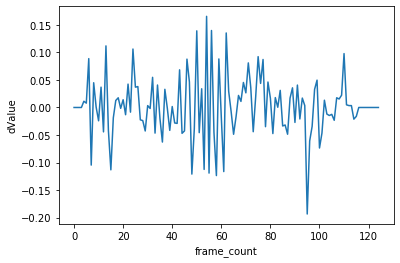

In [65]:
sns.lineplot(x="frame_count", y="dValue",data=df)

In [66]:
df.to_csv('liverpool_value_leicester.csv')